# Experiments with linear models for each family with different strategies for lags

In [1]:
import os
os.chdir(os.environ['PROJECT_ROOT'])

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import sklearn
import pdpipe as pdp
import statsmodels.api as sm
from pandas.core.common import SettingWithCopyWarning
from sklearn.base import BaseEstimator, RegressorMixin, MetaEstimatorMixin, TransformerMixin, clone
from datetime import timedelta
from statistics import median, mean, stdev
from pdpipe import df
from pathlib import Path
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from mentorship.ml.models.reg import PositiveRegressor
from mentorship.ml.models.common import SplitPipeline
from mentorship.ml.models.kaggle.storesales.linear import PipelineLinearV1
from mentorship.features.kaggle.storesales.etl import ETLTransformer
from mentorship.features.history import cut_history
from mentorship.ml.cv.split import DateTimeSeriesSplit
from mentorship.ml.cv.util import print_cv_test_scores


%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

C:\Users\Owner\anaconda3\envs\mentorship_EPAM\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
CV_METRICS = [
    'neg_mean_squared_log_error',
    'neg_root_mean_squared_error',
    'neg_mean_absolute_error',
    # 'neg_mean_absolute_percentage_error',
    'r2'
]

In [4]:
DATA_ROOT = Path('data', 'kaggle', 'store-sales-time-series-forecasting')

In [5]:
train = pd.read_csv(DATA_ROOT / 'train.csv')
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
N_STORES = train['store_nbr'].nunique()
N_FAMILIES = train['family'].nunique()
N_TIME_SERIES = N_STORES * N_FAMILIES

DAYS_IN_YEAR = 365
N_HORIZONS = 16

# 1. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (1 day) (recursive strategy)

In [7]:
X = train.copy()
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [8]:
y = X['sales'].copy()

In [9]:
split_key = 'family'
cols_to_scale = ['dcoilwtico']
cols_to_encode = ['store_nbr']
drop_columns = ['onpromotion']
target_col = 'sales'
lags = [1]

In [10]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_HORIZONS * N_TIME_SERIES)

In [11]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    X_test.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        base_pipeline = PipelineLinearV1(cols_to_scale, cols_to_encode, drop_columns, target_col, lags)
        X_train_current_family = base_pipeline.pipeline(X_train_current_family)
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family, y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family = base_pipeline.pipeline(X_test_current_family)

        previous_day = X_test_current_family['date'].unique()[0]
        for current_day in X_test_current_family['date'].unique()[1:]:
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop(columns=['date', 'pred'])
            predictions = model.predict(X_test_for_current_day)
    
            X_test_current_family.loc[X_test_current_family['date'] == current_day, 'lag_1'] = predictions        
            previous_day = current_day
            
            
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

AttributeError: 'LagComputer' object has no attribute '_desc'

In [19]:
from pdpipe import PdPipelineStage

class LagCreator(PdPipelineStage):
    def __init__(self, target_col, lags):
        self.target_col = target_col
        self.lags = lags

    def _prec(self, X: pd.DataFrame) -> bool:
        if self.target_col not in X.columns:
            return False

        return True

    def _transform(self, X):
        for current_lag in lags:
            X.loc[:, 'lag_{}'.format(current_lag)] = X.groupby(['store_nbr', 'family'])['sales'].shift(current_lag)

        return X

In [20]:
lag_creator = LagCreator(target_col=target_col, lags=lags)
X_new = lag_creator._transform(X)

In [ ]:
keys = np.arange(1, 17)
cv_scores = {key: [] for key in keys}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]

    for i, current_day in enumerate(X_test['date'].unique()):
        X_test_current_day = X_test[X_test['date'] == current_day]
        y_test_current_day = y_test.loc[X_test_current_day.index]
        
        X_test_current_day.loc[:, 'pred'] = 0
        for current_family in X['family'].unique():
            X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
            y_train_current_family = y_train.loc[X_train_current_family.index]
            scaler = MinMaxScaler()
            X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
            
            model = PositiveRegressor(LinearRegression())
            model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
            X_test_current_family = X_test_current_day[X_test_current_day['family'] == current_family].drop(columns=['family'])
            X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])

            previous_day = X_test_current_family['date'].unique()[0]
            for current_day in X_test_current_family['date'].unique()[1:]:
                X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop(columns=['pred', 'date'])
                predictions = model.predict(X_test_for_current_day)
                X_test_current_family.loc[X_test_current_family['date'] == current_day, 'lag_1'] = predictions
                previous_day = current_day
            
        
            y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
            X_test_current_day.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
        y_pred = X_test_current_day['pred'].copy()
        X_test_current_day = X_test_current_day.drop(columns=['pred'])
        cv_scores[i + 1].append(np.sqrt(mean_squared_log_error(y_test_current_day, y_pred)))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

In [ ]:
plt.figure(figsize=(10, 10))
X = list(cv_scores.keys())
y = [mean(cv_scores[key]) for key in X]
plt.plot(X, y)

In [ ]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

test_data = pd.get_dummies(test_data, columns=['store_nbr'], drop_first=True)
test_data['lag_1'] = 0
test_data.loc[test_data[test_data['date'] == test_data['date'].unique()[0]].index, 'lag_1'] = y_train.loc[X_train['date'] == X_train['date'].unique()[-1]].tolist()

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [ ]:
for current_family in X['family'].unique():
    X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train.loc[X_train_current_family.index]
    scaler = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data[test_data['family'] == current_family].drop(columns=['family'])
    
    X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])    
    
    previous_day = X_test_current_family['date'].unique()[0]
    for current_day in X_test_current_family['date'].unique()[1:]:
        X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == previous_day].drop('date', axis=1)
        predictions = model.predict(X_test_for_current_day)
        X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day].index, 'lag_1'] = predictions
        previous_day = current_day
            
    X_test_current_family = X_test_current_family.drop(columns=['date'])
        
    y_pred_current_family = model.predict(X_test_current_family)
        
    test_indices = test_data[test_data['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_dcoilwtico_and_lag_one.csv', index = False)

#### Partial autocorrelation plot for each family with 16 lags (to choose best of them)

In [ ]:
X = train.copy()

first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]

X_train = X_train.groupby(['family', 'date'])['sales'].mean()

for i, current_family in enumerate(X['family'].unique()):
    current_family_sales = X_train.loc[current_family].reset_index()['sales']
    sm.graphics.tsa.plot_pacf(current_family_sales, lags=16)
    plt.title(current_family)
    plt.show()

#### Correlation between 'dcoilwtico' and 'sales' for each family

In [9]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]

df = X_train.groupby(['family', 'date'], as_index=False)[['sales', 'dcoilwtico']].mean()
for current_family, df_family in df.groupby('family'):
    print(current_family)
    print(df_family[['sales', 'dcoilwtico']].corr())
    print('/n/n')

automotive
               sales  dcoilwtico
sales       1.000000    0.190283
dcoilwtico  0.190283    1.000000
/n/n
baby care
               sales  dcoilwtico
sales       1.000000    0.126291
dcoilwtico  0.126291    1.000000
/n/n
beauty
              sales  dcoilwtico
sales       1.00000     0.00748
dcoilwtico  0.00748     1.00000
/n/n
beverages
               sales  dcoilwtico
sales       1.000000    0.088496
dcoilwtico  0.088496    1.000000
/n/n
books
              sales  dcoilwtico
sales       1.00000     0.24685
dcoilwtico  0.24685     1.00000
/n/n
bread/bakery
               sales  dcoilwtico
sales       1.000000    0.025639
dcoilwtico  0.025639    1.000000
/n/n
celebration
               sales  dcoilwtico
sales       1.000000    0.098789
dcoilwtico  0.098789    1.000000
/n/n
cleaning
               sales  dcoilwtico
sales       1.000000    0.101332
dcoilwtico  0.101332    1.000000
/n/n
dairy
               sales  dcoilwtico
sales       1.000000    0.087172
dcoilwtico  0.087172    

# 2. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (1, 2, 4, 6, 7 and 14 days) (recursive strategy)

In [30]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

#lag_computer = LagComputer(target_col=target_col, days_to_shift=days_to_shift)
#lag_computer._fit(X)
#test_data = lag_computer._transform(test_data)

In [31]:
days_to_shift = [1, 2, 4, 6, 7, 14]

In [32]:
lags = {lag:0 for lag in days_to_shift}

X_copy = X.copy()
X_copy['sales'] = np.log(X_copy['sales'] + 1)
for current_lag in lags.keys():
    lags[current_lag] = X_copy.groupby(['store_nbr', 'family'])['sales'].shift(current_lag)

In [33]:
X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)

for current_lag in lags.keys():
    X['lag_{}'.format(current_lag)] = lags[current_lag]

X.head()

,date,family,sales,dcoilwtico,store_nbr_2,store_nbr_3,store_nbr_4,store_nbr_5,store_nbr_6,store_nbr_7,...,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,lag_1,lag_2,lag_4,lag_6,lag_7,lag_14
0,2013-01-01,automotive,0.0,NaN,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-01,baby care,0.0,NaN,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-01,beauty,0.0,NaN,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-01,beverages,0.0,NaN,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-01,books,0.0,NaN,0,0,0,0,0,0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [35]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_HORIZONS * N_TIME_SERIES)

In [36]:
ends = [(16 - x) for x in days_to_shift]
ends.reverse()

In [37]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    y_train = np.log(y_train + 1)
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    X_test.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
                  
        days_to_shift_copy = days_to_shift.copy()
        start = 0
        current_day_index = 0
        for end in ends:
            for current_day in X_test_current_family['date'].unique()[start:end]:
                current_day_plus_x = {}
                for current_lag in days_to_shift_copy:
                    current_day_plus_x[current_lag] = X_test_current_family['date'].unique()[current_day_index + current_lag]
                
                X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date', 'pred'])
                predictions = model.predict(X_test_for_current_day)
                
                for current_lag in days_to_shift_copy:
                    X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day_plus_x[current_lag]].index, 'lag_{}'.format(current_lag)] = predictions
                    
                current_day_index += 1
                
            days_to_shift_copy = days_to_shift_copy[:-1]
            start = end

            
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
    y_pred = X_test['pred'].copy()
    y_pred = np.exp(y_pred) - 1
    X_test = X_test.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

RMSLE: 0.459 ± 0.028
RMSE: 366.457 ± 51.384
MAE: 97.536 ± 6.031
R2: 0.920 ± 0.017


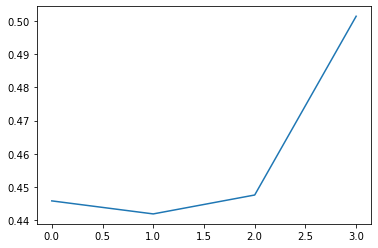

In [38]:
plt.plot(scores['RMSLE'])

In [54]:
X_train, y_train = cut_history(X=X, date_column='date', keep_interval=timedelta(days=365), y=y)
y_train = np.log(y_train + 1)

In [58]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

for current_lag in days_to_shift:
    test_data.loc[:, 'lag_{}'.format(current_lag)] = 0
    
    for i in range(current_lag):
        test_data.loc[test_data[test_data['date'] == test_data['date'].unique()[i]].index, 'lag_{}'.format(current_lag)] = y_train.loc[X_train['date'] == X_train['date'].unique()[-(current_lag - i)]].tolist()
        
test_data = pd.get_dummies(test_data, columns=['store_nbr'], drop_first=True)

In [59]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [61]:
for current_family in X['family'].unique():
    X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train.loc[X_train_current_family.index]
    scaler = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data[test_data['family'] == current_family].drop(columns=['family'])
    X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])    
    
    days_to_shift_copy = days_to_shift.copy()
    start = 0
    current_day_index = 0
    for end in ends:
        for current_day in X_test_current_family['date'].unique()[start:end]:
            current_day_plus_x = {}
            for current_lag in days_to_shift_copy:
                current_day_plus_x[current_lag] = X_test_current_family['date'].unique()[current_day_index + current_lag]
                
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date'])
            predictions = model.predict(X_test_for_current_day)
                
            for current_lag in days_to_shift_copy:
                X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day_plus_x[current_lag]].index, 'lag_{}'.format(current_lag)] = predictions
                    
            current_day_index += 1
                
        days_to_shift_copy = days_to_shift_copy[:-1]
        start = end
            
        
    y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date']))
    y_pred_current_family = np.exp(y_pred_current_family) - 1
    
    test_indices = test_data[test_data['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [62]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_best_lags_only.csv', index = False)

# 3. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (1 - 16 days) (recursive strategy)

In [ ]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
days_to_shift = list(range(1, 17))

In [ ]:
X = X[X['dcoilwtico'].notna()]
X = X.reset_index(drop=True)

for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [ ]:
X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)
X.head()

In [ ]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [ ]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_HORIZONS * N_TIME_SERIES)

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    X_test.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
                  

        for i, current_day in enumerate(X_test_current_family['date'].unique()):
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date', 'pred'])
            predictions = model.predict(X_test_for_current_day)
            
            for j in range(1, 16 - i):
                next_day = X_test_current_family['date'].unique()[i + j]
                X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == next_day].index, 'lag_{}'.format(j)] = predictions
        
        
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        y_pred_current_family[y_pred_current_family < 0] = 0
        X_test.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

In [ ]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train = y.loc[indexer]

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

for current_lag in days_to_shift:
    test_data.loc[:, 'lag_{}'.format(current_lag)] = 0
    
    for i in range(current_lag):
        test_data.loc[test_data[test_data['date'] == test_data['date'].unique()[i]].index, 'lag_{}'.format(current_lag)] = y_train.loc[X_train['date'] == X_train['date'].unique()[-(current_lag - i)]].tolist()

test_data = pd.get_dummies(test_data, columns=['store_nbr'], drop_first=True)

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [ ]:
for current_family in X['family'].unique():
    X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train.loc[X_train_current_family.index]
    scaler = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data[test_data['family'] == current_family].drop(columns=['family'])
    X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])    
    
    for i, current_day in enumerate(X_test_current_family['date'].unique()):
        X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date'])
        predictions = model.predict(X_test_for_current_day)
        predictions[predictions < 0] = 0
            
        for j in range(1, 16 - i):
            next_day = X_test_current_family['date'].unique()[i + j]
            X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == next_day].index, 'lag_{}'.format(j)] = predictions
            
            
        
    y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date']))
    y_pred_current_family[y_pred_current_family < 0] = 0
        
    test_indices = test_data[test_data['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_dcoilwtico_and_lags.csv', index = False)

# 4. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (1 - 16, 30 days) (recursive strategy)

In [ ]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
days_to_shift = list(range(1, 17))

In [ ]:
X = X[X['dcoilwtico'].notna()]
X = X.reset_index(drop=True)

for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)
lags[30] = X.groupby(['store_nbr', 'family'])['sales'].shift(30)

In [ ]:
X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)
X.head()

In [ ]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [ ]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_HORIZONS * N_TIME_SERIES)

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    X_test.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
                  

        for i, current_day in enumerate(X_test_current_family['date'].unique()):
            X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date', 'pred'])
            predictions = model.predict(X_test_for_current_day)
            
            for j in range(1, 16 - i):
                next_day = X_test_current_family['date'].unique()[i + j]
                X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == next_day].index, 'lag_{}'.format(j)] = predictions
        
        
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

In [ ]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]
y_train = y.loc[indexer]

In [ ]:
test_data = pd.read_csv(DATA_ROOT / 'test.csv').drop(columns=['onpromotion'])
test_transformer = ETLTransformer(date_column='date', id_column='id')
test_data = test_transformer.transform(test_data)[0]

for current_lag in days_to_shift:
    test_data.loc[:, 'lag_{}'.format(current_lag)] = 0
    
    for i in range(current_lag):
        test_data.loc[test_data[test_data['date'] == test_data['date'].unique()[i]].index, 'lag_{}'.format(current_lag)] = y_train.loc[X_train['date'] == X_train['date'].unique()[-(current_lag - i)]].tolist()

test_data.loc[:, 'lag_30'] = 0
for i in range(30):
    test_data.loc[test_data[test_data['date'] == test_data['date'].unique()[j]].index, 'lag_30'] = y_train.loc[X_train['date'] == X_train['date'].unique()[-(30 - j)]].tolist()

test_data = pd.get_dummies(test_data, columns=['store_nbr'], drop_first=True)

In [ ]:
submission = pd.read_csv(DATA_ROOT / 'sample_submission.csv')

In [ ]:
for current_family in X['family'].unique():
    X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
    y_train_current_family = y_train.loc[X_train_current_family.index]
    scaler = MinMaxScaler()
    X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
    
    model = PositiveRegressor(LinearRegression())
    model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
    
    X_test_current_family = test_data[test_data['family'] == current_family].drop(columns=['family'])
    X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])    
    
    for i, current_day in enumerate(X_test_current_family['date'].unique()):
        X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date'])
        predictions = model.predict(X_test_for_current_day)
            
        for j in range(1, 16 - i):
            next_day = X_test_current_family['date'].unique()[i + j]
            X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == next_day].index, 'lag_{}'.format(j)] = predictions
            
            
        
    y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date']))
        
    test_indices = test_data[test_data['family'] == current_family].index
    submission.loc[test_indices, 'sales'] = y_pred_current_family

In [ ]:
submission.to_csv('./data/kaggle/store-sales-time-series-forecasting/linreg_dcoilwtico_and_lags_v30.csv', index = False)

# 5. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' feature (1, 2, 4, 6, 7 and 14 days) (direct strategy v1)

In [ ]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
days_to_shift = [1, 2, 4, 6, 7, 14]

In [ ]:
for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [ ]:
targets = pd.DataFrame(index=range(X.shape[0]))
for i in range(16):
    targets.loc[:, '-{}'.format(i + 1)] = X.groupby(['store_nbr', 'family'])['sales'].shift(-(i + 1))

X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)
X.head()

In [ ]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [ ]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_TIME_SERIES)

In [ ]:
targets_nan_ind = targets[targets.isna().any(axis=1)].index
targets = targets.dropna()
X_without_last_days = X.copy().drop(labels = targets_nan_ind)
y_without_last_days = y.copy().drop(labels = targets_nan_ind) 

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X_without_last_days, y_without_last_days):
    X_train = X.iloc[train_indices]
    y_train = targets.iloc[train_indices]
    X_test = X.iloc[test_indices]
    
    first_day_pred = pd.to_datetime(X_test['date'].unique()[-1]) + timedelta(days=1)
    last_day_pred = first_day_pred + timedelta(days=16)
    first_day_pred = str(first_day_pred).split(' ')[0]
    last_day_pred = str(last_day_pred).split(' ')[0]
    
    X_test_with_pred = X[(X['date'] >= first_day_pred) & (X['date'] < last_day_pred)]
    y_test = y.loc[X_test_with_pred.index]
        
    X_test_with_pred.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
        model = MultiOutputRegressor(PositiveRegressor(LinearRegression()))
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
        
        predictions = model.predict(X_test_current_family.drop(columns=['date']))
        
        for i in range(predictions.shape[1]):
            X_test_with_pred.loc[(X_test_with_pred['date'] == X_test_with_pred['date'].unique()[i]) & \
                                                  (X_test_with_pred['family'] == current_family), 'pred'] = predictions[:, i].tolist()
        
    y_pred = X_test_with_pred['pred'].copy()
    X_test_with_pred = X_test_with_pred.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

In [ ]:
for metric_name, metric_values in scores.items():
    print(metric_name, metric_values)

In [ ]:
X = train.copy()

for i in range(16):
    X.loc[:, '{} day'.format(i + 1)] = X.groupby(['store_nbr', 'family'])['sales'].shift(-(i + 1))

X_copy = X.dropna()

first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
X_train = X_copy[X_copy['date'] >= str(first_day_of_last_year).split(' ')[0]]

for i in range(16):
    print('{} day'.format(i + 1))
    X_train_current_lag = X_train.groupby(['family', 'date'])['{} day'.format(i + 1)].mean()
    for current_family in X['family'].unique():
        current_sales_current_family = X_train_current_lag.loc[current_family].reset_index()['{} day'.format(i + 1)]
        sm.graphics.tsa.plot_pacf(current_sales_current_family, lags=16)
        plt.title(current_family)
        plt.show()
    print()
    print()

# 6. Linear Regression with 'store_nbr', 'dcoilwtico' and 'lag' features (direct strategy v2)

In [63]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [64]:
days_to_shift = range(16)

for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [66]:
targets = pd.DataFrame(index=range(X.shape[0]))

for i in range(16):
    targets.loc[:, '-{}'.format(i + 1)] = X.groupby(['store_nbr', 'family'])['sales'].shift(-(i + 1))

X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)

X.head()

,date,family,sales,dcoilwtico,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,2013-01-02,automotive,2.0,93.14,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,baby care,0.0,93.14,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-02,beauty,2.0,93.14,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-02,beverages,1091.0,93.14,1091.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-02,books,0.0,93.14,0.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [67]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [68]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_TIME_SERIES)

In [69]:
lags_for_test_each_horizon = {1: [0, 1, 3, 5, 6, 13], 2: [0, 2, 4, 5, 12], 3: [1, 3, 4, 11], 4: [0, 2, 3, 10],
                              5: [1, 2, 9], 6: [0, 1, 8], 7: [0, 7], 8: [6], 9: [5], 10: [4], 11: [3], 12: [2],
                              13: [1], 14: [0], 15: [], 16: []}

In [70]:
targets_nan_ind = targets[targets.isna().any(axis=1)].index
targets = targets.dropna()
X_without_last_days = X.copy().drop(labels = targets_nan_ind)
y_without_last_days = y.copy().drop(labels = targets_nan_ind) 

In [72]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X_without_last_days, y_without_last_days):
    X_train = X.iloc[train_indices]
    y_train = targets.iloc[train_indices]
    X_test = X.iloc[test_indices]
    
    first_day_pred = pd.to_datetime(X_test['date'].unique()[-1]) + timedelta(days=1)
    last_day_pred = first_day_pred + timedelta(days=16)
    first_day_pred = str(first_day_pred).split(' ')[0]
    last_day_pred = str(last_day_pred).split(' ')[0]
    
    X_test_with_pred_ind = X[(X['date'] >= first_day_pred) & (X['date'] < last_day_pred)].index
    X_test_with_pred = X[(X['date'] >= first_day_pred) & (X['date'] < last_day_pred)]
    y_test = y.loc[X_test_with_pred_ind]
        
    X_test_with_pred.loc[:, 'pred'] = 0
    for current_horizon in range(1, 17):
        print(current_horizon)
        lags_for_train_current_horizon = [(x + 1) for x in lags_for_test_each_horizon[current_horizon]]
        X_train_current_horizon = X_train.drop(columns=['lag_{}'.format(x) for x in days_to_shift if x not in lags_for_train_current_horizon])
        X_test_current_horizon = X_test.drop(columns=['lag_{}'.format(x) for x in days_to_shift if x not in lags_for_test_each_horizon[current_horizon]])
        y_train_current_horizon = y_train['-{}'.format(current_horizon - 1)]
        
        for current_family in X['family'].unique():
            X_train_current_family = X_train_current_horizon[X_train_current_horizon['family'] == current_family].drop(columns=['family'])
            y_train_current_family = y_train_current_horizon.loc[X_train_current_family.index]
            scaler = MinMaxScaler()
            X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
            model = PositiveRegressor(LinearRegression())
            model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
            X_test_current_family = X_test_current_horizon[X_test_current_horizon['family'] == current_family].drop(columns=['family'])
            X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
        
            predictions = model.predict(X_test_current_family.drop(columns=['date']))
        
            X_test_with_pred.loc[X_test_with_pred[(X_test_with_pred['date'] == X_test_with_pred['date'].unique()[current_horizon - 1]) & \
                                                  (X_test_with_pred['family'] == current_family)].index, 'pred'] = predictions.tolist()
        
    y_pred = X_test_with_pred['pred'].copy()
    X_test_with_pred = X_test_with_pred.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

1
automotive


KeyError: "None of [Int64Index([2963466, 2963499, 2963532, 2963565, 2963598, 2963631, 2963664,\n            2963697, 2963730, 2963763, 2963796, 2963829, 2963862, 2963895,\n            2963928, 2963961, 2963994, 2964027, 2964060, 2964093, 2964126,\n            2964159, 2964192, 2964225, 2964258, 2964291, 2964324, 2964357,\n            2964390, 2964423, 2964456, 2964489, 2964522, 2964555, 2964588,\n            2964621, 2964654, 2964687, 2964720, 2964753, 2964786, 2964819,\n            2964852, 2964885, 2964918, 2964951, 2964984, 2965017, 2965050,\n            2965083, 2965116, 2965149, 2965182, 2965215],\n           dtype='int64')] are in the [index]"

In [ ]:
for metric_name, metric_values in scores.items():
    print(metric_name, metric_values)

# 7. Linear Regression, features: 'store_nbr', 'dcoilwtico' with 'lags' (1 day shift) and 'lags' for target (1, 2, 4, 6, 7, 14 days shift) (direct-recursive strategy)

In [ ]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [ ]:
days_to_shift = [1, 2, 4, 6, 7, 14]

for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [ ]:
targets = pd.DataFrame(index=range(X.shape[0]))

for i in range(16):
    targets.loc[:, '-{}'.format(i + 1)] = X.groupby(['store_nbr', 'family'])['sales'].shift(-(i + 1))

X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)

X.head()

In [ ]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [ ]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_TIME_SERIES)

In [ ]:
lags_for_test_each_horizon = {1: [0, 1, 3, 5, 6, 13], 2: [0, 2, 4, 5, 12], 3: [1, 3, 4, 11], 4: [0, 2, 3, 10],
                              5: [1, 2, 9], 6: [0, 1, 8], 7: [0, 7], 8: [6], 9: [5], 10: [4], 11: [3], 12: [2],
                              13: [1], 14: [0], 15: [], 16: []}

In [ ]:
targets_nan_ind = targets[targets.isna().any(axis=1)].index
targets = targets.dropna()
X_without_last_days = X.copy().drop(labels = targets_nan_ind)
y_without_last_days = y.copy().drop(labels = targets_nan_ind)

In [ ]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X_without_last_days, y_without_last_days):
    lags_for_horizons_during_direct = {horizon:{} for horizon in range(2, 17)}
    X_train = X.iloc[train_indices]
    y_train = targets.iloc[train_indices]
    X_test = X.iloc[test_indices]
    
    first_day_pred = pd.to_datetime(X_test['date'].unique()[-1]) + timedelta(days=1)
    last_day_pred = first_day_pred + timedelta(days=16)
    first_day_pred = str(first_day_pred).split(' ')[0]
    last_day_pred = str(last_day_pred).split(' ')[0]
    
    X_test_with_pred_ind = X[(X['date'] >= first_day_pred) & (X['date'] < last_day_pred)].index
    X_test_with_pred = X[(X['date'] >= first_day_pred) & (X['date'] < last_day_pred)]
    y_test = y.loc[X_test_with_pred_ind]
        
    X_test_with_pred.loc[:, 'pred'] = 0
    for current_horizon in range(1, 17):
        unknown_lags_for_current_horizon = [x for x in days_to_shift if x < current_horizon]
        X_train_current_horizon = X_train.copy()
        y_train_current_horizon = y_train['-{}'.format(current_horizon)]
        X_test_current_horizon = X_test.copy()
        for unknown_lag in ['lag_{}'.format(x) for x in unknown_lags_for_current_horizon]:
            X_test_current_horizon[unknown_lag] = lags_for_horizons_during_direct[current_horizon][unknown_lag].copy()
        
        for current_family in X['family'].unique():
            X_train_current_family = X_train_current_horizon[X_train_current_horizon['family'] == current_family].drop(columns=['family'])
            y_train_current_family = y_train_current_horizon.loc[X_train_current_family.index]
            scaler = MinMaxScaler()
            X_train_current_family[['dcoilwtico']] = scaler.fit_transform(X_train_current_family[['dcoilwtico']])
        
            model = PositiveRegressor(LinearRegression())
            model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
            X_test_current_family = X_test_current_horizon[X_test_current_horizon['family'] == current_family].drop(columns=['family'])
            X_test_current_family[['dcoilwtico']] = scaler.transform(X_test_current_family[['dcoilwtico']])
        
            predictions = model.predict(X_test_current_family.drop(columns=['date']))
        
            X_test_with_pred.loc[X_test_with_pred[(X_test_with_pred['date'] == X_test_with_pred['date'].unique()[current_horizon - 1]) & \
                                                  (X_test_with_pred['family'] == current_family)].index, 'pred'] = predictions.tolist()
        
        
        current_horizon_predictions = X_test_with_pred[X_test_with_pred['date'] == X_test_with_pred['date'].unique()[current_horizon - 1]]['pred'].tolist()
        
        future_horizons = [(current_horizon + x) for x in days_to_shift if current_horizon + x <= 16]
        for future_horizon in future_horizons:
            lags_for_horizons_during_direct[future_horizon]['lag_{}'.format(future_horizon - current_horizon)] = current_horizon_predictions

        
    y_pred = X_test_with_pred['pred'].copy()
    X_test_with_pred = X_test_with_pred.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

In [ ]:
print(scores)

# 8. Linear Regression, features: 'store_nbr', 'dcoilwtico' with 'lags' (1 day shift) and 'lags' for target (1, 2, 4, 6, 7, 14 days shift) (recursive strategy)

In [91]:
X = train.copy().drop(columns='onpromotion')
train_transformer = ETLTransformer(date_column='date', id_column='id')
X = train_transformer.transform(X)[0]

In [92]:
days_to_shift = [1, 2, 4, 6, 7, 14]

for lag in days_to_shift:
    X[f'lag_{lag}'] = X.groupby(['store_nbr', 'family'])['sales'].shift(lag)

In [93]:
X = pd.get_dummies(X, columns=['store_nbr'], drop_first=True)
X.head()

,date,family,sales,dcoilwtico,lag_1,lag_2,lag_4,lag_6,lag_7,lag_14,...,store_nbr_45,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54
0,2013-01-01,automotive,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-01,baby care,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-01,beauty,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-01,beverages,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-01,books,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [94]:
y = X['sales'].copy()
X = X.drop(columns=['sales'])

In [95]:
first_day_of_last_year = pd.to_datetime(X['date'].unique()[-1]) - timedelta(days=365)
indexer = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]].index
X_train = X[X['date'] >= str(first_day_of_last_year).split(' ')[0]]

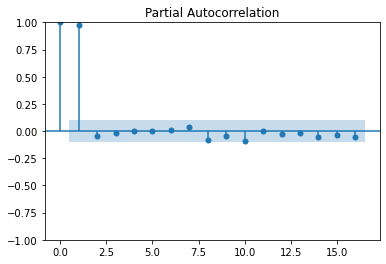

In [96]:
oil_price = X_train.groupby('date')['dcoilwtico'].mean().reset_index()['dcoilwtico']
sm.graphics.tsa.plot_pacf(oil_price, lags=16)
plt.show()

In [97]:
lag_1_oil = pd.DataFrame(data=X.groupby(['date'])['dcoilwtico'].mean())
lag_1_oil['dcoilwtico'] = lag_1_oil['dcoilwtico'].shift()
lag_1_oil = lag_1_oil.rename(columns={'dcoilwtico': 'lag_1_oil'})
X = X.merge(lag_1_oil, on='date', how='left')
X.head()

,date,family,dcoilwtico,lag_1,lag_2,lag_4,lag_6,lag_7,lag_14,store_nbr_2,...,store_nbr_46,store_nbr_47,store_nbr_48,store_nbr_49,store_nbr_50,store_nbr_51,store_nbr_52,store_nbr_53,store_nbr_54,lag_1_oil
0,2013-01-01,automotive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
1,2013-01-01,baby care,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
2,2013-01-01,beauty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
3,2013-01-01,beverages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN
4,2013-01-01,books,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,...,0,0,0,0,0,0,0,0,0,NaN


In [98]:
tscv = TimeSeriesSplit(gap=0, max_train_size=DAYS_IN_YEAR * N_TIME_SERIES, n_splits=4, test_size=N_HORIZONS * N_TIME_SERIES)

In [99]:
ends = [(16 - x) for x in days_to_shift]
ends.reverse()

In [102]:
scores = {'RMSLE': [], 'RMSE': [], 'MAE': [], 'R2': []}

for train_indices, test_indices in tscv.split(X, y):
    X_train = X.iloc[train_indices]
    y_train = y.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_test = y.iloc[test_indices]
    
    X_test.loc[:, 'pred'] = 0
    for current_family in X['family'].unique():
        print(current_family)
        X_train_current_family = X_train[X_train['family'] == current_family].drop(columns=['family'])
        y_train_current_family = y_train.loc[X_train_current_family.index]
        scaler = MinMaxScaler()
        X_train_current_family[['dcoilwtico', 'lag_1_oil']] = scaler.fit_transform(X_train_current_family[['dcoilwtico', 'lag_1_oil']])
        
        model = PositiveRegressor(LinearRegression())
        model.fit(X_train_current_family.drop(columns=['date']), y_train_current_family)
        
        X_test_current_family = X_test[X_test['family'] == current_family].drop(columns=['family'])
        X_test_current_family[['dcoilwtico', 'lag_1_oil']] = scaler.transform(X_test_current_family[['dcoilwtico', 'lag_1_oil']])
                  
        days_to_shift_copy = days_to_shift.copy()
        start = 0
        current_day_index = 0
        for end in ends:
            for current_day in X_test_current_family['date'].unique()[start:end]:
                current_day_plus_x = {}
                for current_lag in days_to_shift_copy:
                    current_day_plus_x[current_lag] = X_test_current_family['date'].unique()[current_day_index + current_lag]
                
                X_test_for_current_day = X_test_current_family[X_test_current_family['date'] == current_day].drop(columns=['date', 'pred'])
                predictions = model.predict(X_test_for_current_day)
                
                for current_lag in days_to_shift_copy:
                    X_test_current_family.loc[X_test_current_family[X_test_current_family['date'] == current_day_plus_x[current_lag]].index, 'lag_{}'.format(current_lag)] = predictions
                    
                current_day_index += 1
                
            days_to_shift_copy = days_to_shift_copy[:-1]
            start = end

            
        y_pred_current_family = model.predict(X_test_current_family.drop(columns=['date', 'pred']))
        X_test.loc[X_test_current_family.index, 'pred'] = y_pred_current_family
        
    y_pred = X_test['pred'].copy()
    X_test = X_test.drop(columns=['pred'])
    
    scores['RMSLE'].append(np.sqrt(mean_squared_log_error(y_test, y_pred)))
    scores['RMSE'].append(mean_squared_error(y_test, y_pred, squared=False))
    scores['MAE'].append(mean_absolute_error(y_test, y_pred))
    scores['R2'].append(r2_score(y_test, y_pred))

for metric_name, metric_values in scores.items():
    print(f'{metric_name}: {mean(metric_values):.3f} ± {stdev(metric_values):.3f}')

automotive
baby care
beauty
beverages
books
bread/bakery
celebration
cleaning
dairy
deli
eggs
frozen foods
grocery i
grocery ii
hardware
home and kitchen i
home and kitchen ii
home appliances
home care
ladieswear
lawn and garden
lingerie
liquor,wine,beer
magazines
meats
personal care
pet supplies
players and electronics
poultry
prepared foods
produce
school and office supplies
seafood
automotive
baby care
beauty
beverages
books
bread/bakery
celebration
cleaning
dairy
deli
eggs
frozen foods
grocery i
grocery ii
hardware
home and kitchen i
home and kitchen ii
home appliances
home care
ladieswear
lawn and garden
lingerie
liquor,wine,beer
magazines
meats
personal care
pet supplies
players and electronics
poultry
prepared foods
produce
school and office supplies
seafood
automotive
baby care
beauty
beverages
books
bread/bakery
celebration
cleaning
dairy
deli
eggs
frozen foods
grocery i
grocery ii
hardware
home and kitchen i
home and kitchen ii
home appliances
home care
ladieswear
lawn and ga

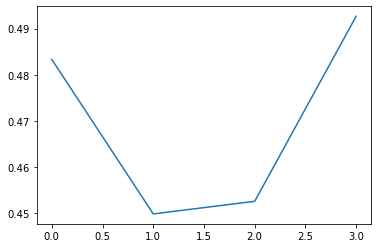

In [103]:
plt.plot(scores['RMSLE'])